In [46]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import lightgbm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import lightgbm as lgb

from tqdm import tqdm
import warnings

%matplotlib inline
warnings.filterwarnings(action = 'ignore')
pd.set_option('display.max_columns', 500)

In [9]:
def split_y(data, col) :
    X = data.iloc[:, :-4]
    y = data.iloc[:, -4:]
    
    y = y[col]
    
    data = pd.concat([X,y], axis=1)
    
    return data

# 1. Data load

In [10]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [11]:
train

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,740_src,750_src,760_src,770_src,780_src,790_src,800_src,810_src,820_src,830_src,840_src,850_src,860_src,870_src,880_src,890_src,900_src,910_src,920_src,930_src,940_src,950_src,960_src,970_src,980_src,990_src,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,750_dst,760_dst,770_dst,780_dst,790_dst,800_dst,810_dst,820_dst,830_dst,840_dst,850_dst,860_dst,870_dst,880_dst,890_dst,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst,hhb,hbo2,ca,na
0,0,25,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,0.96333,1.01541,0.99865,0.94373,0.84513,0.74023,0.68776,0.57697,0.51536,0.43508,0.36501,0.34935,0.30038,0.26992,0.23192,0.21998,0.19920,0.14493,0.13150,0.12442,0.10786,0.11984,0.09851,0.10965,0.07424,0.07777,0.05536,2.447758e-18,1.894578e-18,0.000000e+00,6.412913e-18,1.098559e-17,8.907142e-19,NaN,0.000000e+00,NaN,0.000000e+00,5.901745e-18,NaN,1.176812e-18,NaN,5.557492e-17,1.046498e-16,NaN,7.236748e-17,4.021610e-17,2.397489e-17,1.870153e-17,1.808920e-17,NaN,0.000000e+00,2.626216e-18,NaN,3.527371e-18,NaN,6.455564e-19,NaN,0.000000e+00,NaN,1.067504e-18,5.998949e-18,4.378513e-17,5.59,4.32,8.92,4.29
1,1,10,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,0.00000,0.01295,0.00000,0.01565,0.00000,0.00000,0.01285,0.01129,0.00359,0.00000,0.00000,0.00000,0.00000,0.00000,0.04466,0.10738,0.21646,0.41456,0.63716,0.84230,0.97480,0.99803,0.97146,0.87045,0.75330,0.63414,0.53699,0.000000e+00,0.000000e+00,0.000000e+00,1.995530e-10,1.025259e-10,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,1.151021e-10,4.318673e-10,2.753933e-10,0.000000e+00,8.138830e-10,6.522110e-10,NaN,2.732232e-10,NaN,7.663267e-11,NaN,1.389496e-10,1.472282e-09,1.450463e-09,1.225321e-09,2.647633e-09,NaN,5.233480e-09,1.264238e-08,1.343132e-08,6.112685e-09,2.130547e-09,NaN,9.710091e-09,NaN,0.00,2.83,7.25,4.64
2,2,25,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,0.25584,0.30445,0.38962,0.50472,0.56934,0.67742,0.79720,0.87593,0.92783,0.99498,0.98682,0.98988,0.95101,0.89853,0.79813,0.68262,0.58043,0.46222,0.39113,0.27879,0.19070,0.16603,0.11617,0.06744,0.02343,0.03926,0.03136,1.677445e-19,3.763590e-20,NaN,0.000000e+00,NaN,NaN,8.981651e-19,1.944683e-19,8.126907e-19,2.183200e-19,3.349335e-19,NaN,0.000000e+00,2.630961e-18,NaN,0.000000e+00,9.912979e-18,1.112747e-17,NaN,NaN,NaN,1.260239e-19,NaN,0.000000e+00,3.876159e-18,4.629125e-18,1.409413e-18,3.237480e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.329725e-18,NaN,10.64,3.00,8.40,5.16
3,3,10,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,0.79865,0.91482,0.95274,0.99391,1.00563,0.93165,0.84703,0.74997,0.67765,0.58432,0.50642,0.43087,0.35684,0.30786,0.27722,0.24119,0.20158,0.17876,0.15139,0.15656,0.13392,0.14247,0.10126,0.09928,0.09239,0.10523,0.06349,4.044975e-11,NaN,5.345363e-11,9.106886e-12,1.881458e-11,3.617201e-11,7.909656e-13,NaN,1.583839e-10,NaN,1.678049e-10,2.814419e-10,4.429321e-10,1.319956e-09,2.269806e-09,2.679164e-09,2.538200e-09,2.046841e-09,1.516820e-09,1.328007e-09,1.061359e-09,8.634016e-10,5.804951e-10,3.615067e-10,NaN,1.274876e-10,6.118947e-11,NaN,1.663888e-10,2.245998e-10,1.299511e-10,7.782625e-11,NaN,4.088921e-10,NaN,5.67,4.01,5.05,4.35
4,4,15,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,1.01564,1.00216,1.01190,1.00344,0.98365,1.01350,1.01649,0.98220,0.99091,0.99258,1.00175,0.98861,0.98270,1.00432,1.01434,1.01455,0.98861,0.98300,1.00616,0.99045,1.01321,1.01559,1.01072,0.99439,0.98597,0.99889,1.01412,4.784751e-14,NaN,0.000000e+00,1.153089e-13,0.000000e+00,0.000000e+00,1.056991e-13,0.000000e+00,0.000000e+00,2.666663e-14,1.493071e-14,NaN,0.000000e+00,1.200730e-13,2.648249e-13,NaN,4.392331e-13,2.831191e-13,4.557059e-13,1.326038e-13,1.864796e-13,1.419359e-13,1.765559e-13,1.593789e-13,NaN,0.000000e+00,NaN,1.537619e-14,4.996522e-14,1.457955e-13,8.769053e-14,NaN,1.330237e-13,NaN,NaN,11.9

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 76 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       10000 non-null  int64  
 1   rho      10000 non-null  int64  
 2   650_src  10000 non-null  float64
 3   660_src  10000 non-null  float64
 4   670_src  10000 non-null  float64
 5   680_src  10000 non-null  float64
 6   690_src  10000 non-null  float64
 7   700_src  10000 non-null  float64
 8   710_src  10000 non-null  float64
 9   720_src  10000 non-null  float64
 10  730_src  10000 non-null  float64
 11  740_src  10000 non-null  float64
 12  750_src  10000 non-null  float64
 13  760_src  10000 non-null  float64
 14  770_src  10000 non-null  float64
 15  780_src  10000 non-null  float64
 16  790_src  10000 non-null  float64
 17  800_src  10000 non-null  float64
 18  810_src  10000 non-null  float64
 19  820_src  10000 non-null  float64
 20  830_src  10000 non-null  float64
 21  840_src  1000

# 2. EDA

### Data scaling 

src data and dst data are tiny compared dependent data  
So do a scaling using robust scaler   
The reason of using robust scaler is in here  
https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf

In [13]:
#set dst columns
src_column = train.iloc[:,2:37].columns
dst_column = train.iloc[:,37:72].columns

#scaling using scikit learn's robust scaling
src_scaler = RobustScaler().fit(train[src_column])
src_scale = src_scaler.transform(train[src_column])

dst_scaler = RobustScaler().fit(train[dst_column])
dst_scale = dst_scaler.transform(train[dst_column])

#change the result to dataframe and replace train data
src_scale = pd.DataFrame(src_scale)
dst_scale = pd.DataFrame(dst_scale)

train[src_column] = src_scale
train[dst_column] = dst_scale

### Elimination null value

In [14]:
#check train data's null
train_column = train.columns
train_null_column = []

for col in train_column :
    null = train[col].isnull().sum()
    if null > 0 :
        print('null number of {0} column : {1}'.format(col, null))
        train_null_column.append(col)

null number of 650_dst column : 1948
null number of 660_dst column : 1988
null number of 670_dst column : 1931
null number of 680_dst column : 1975
null number of 690_dst column : 2003
null number of 700_dst column : 1966
null number of 710_dst column : 1946
null number of 720_dst column : 2046
null number of 730_dst column : 2006
null number of 740_dst column : 1993
null number of 750_dst column : 2071
null number of 760_dst column : 2050
null number of 770_dst column : 1994
null number of 780_dst column : 1945
null number of 790_dst column : 2059
null number of 800_dst column : 2026
null number of 810_dst column : 1990
null number of 820_dst column : 2091
null number of 830_dst column : 1965
null number of 840_dst column : 2045
null number of 850_dst column : 2014
null number of 860_dst column : 2010
null number of 870_dst column : 2020
null number of 880_dst column : 1968
null number of 890_dst column : 2059
null number of 900_dst column : 1999
null number of 910_dst column : 2030
n

In [15]:
#check test data's null
test_column = test.columns
test_null_column = []

for col in test_column :
    null = test[col].isnull().sum()
    if null > 0 :
        print('null number of {0} column : {1}'.format(col, null))
        test_null_column.append(col)

null number of 650_dst column : 2026
null number of 660_dst column : 1960
null number of 670_dst column : 2015
null number of 680_dst column : 2006
null number of 690_dst column : 1985
null number of 700_dst column : 1948
null number of 710_dst column : 2043
null number of 720_dst column : 2014
null number of 730_dst column : 2038
null number of 740_dst column : 1999
null number of 750_dst column : 1965
null number of 760_dst column : 2000
null number of 770_dst column : 1956
null number of 780_dst column : 2020
null number of 790_dst column : 2030
null number of 800_dst column : 1961
null number of 810_dst column : 2034
null number of 820_dst column : 2042
null number of 830_dst column : 2058
null number of 840_dst column : 1947
null number of 850_dst column : 2005
null number of 860_dst column : 2008
null number of 870_dst column : 2063
null number of 880_dst column : 2080
null number of 890_dst column : 1996
null number of 900_dst column : 1976
null number of 910_dst column : 1919
n

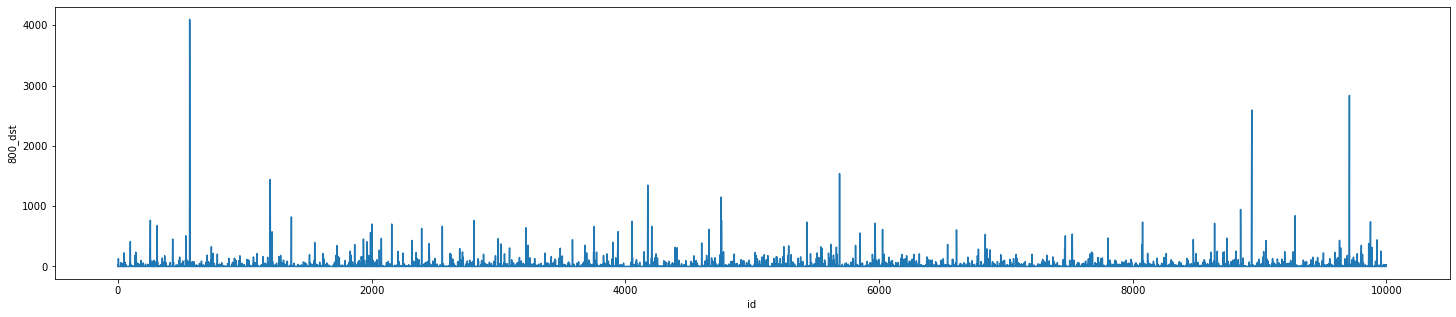

In [16]:
fig, ax = plt.subplots(figsize = (25, 5))

sns.lineplot(x = train['id'], y = train['800_dst'], ax = ax)
plt.show()

In [17]:
print('mean : {}'.format(train['650_dst'].mean()))
print('median : {}'.format(train['650_dst'].median()))
print('mode : {}'.format(train['650_dst'].mode()))

mean : 1041.9509177260513
median : 4.460157862885925e-21
mode : 0   -0.000065
dtype: float64


**Since zero appears most frequently, it is safe to replace all values with zero.**

In [18]:
#replace each column's null, as a median of column
for col in train_null_column :
    train[col].fillna(0, inplace = True)
    
for col in test_null_column :
    test[col].fillna(0, inplace = True)

### Calculate correlation between dependent variables and src&dst datas

In [19]:
src_column = list(src_column)
dst_column = list(dst_column)

for col in ['hhb', 'hbo2', 'ca', 'na'] : 
    src_column.append(col)
    dst_column.append(col)

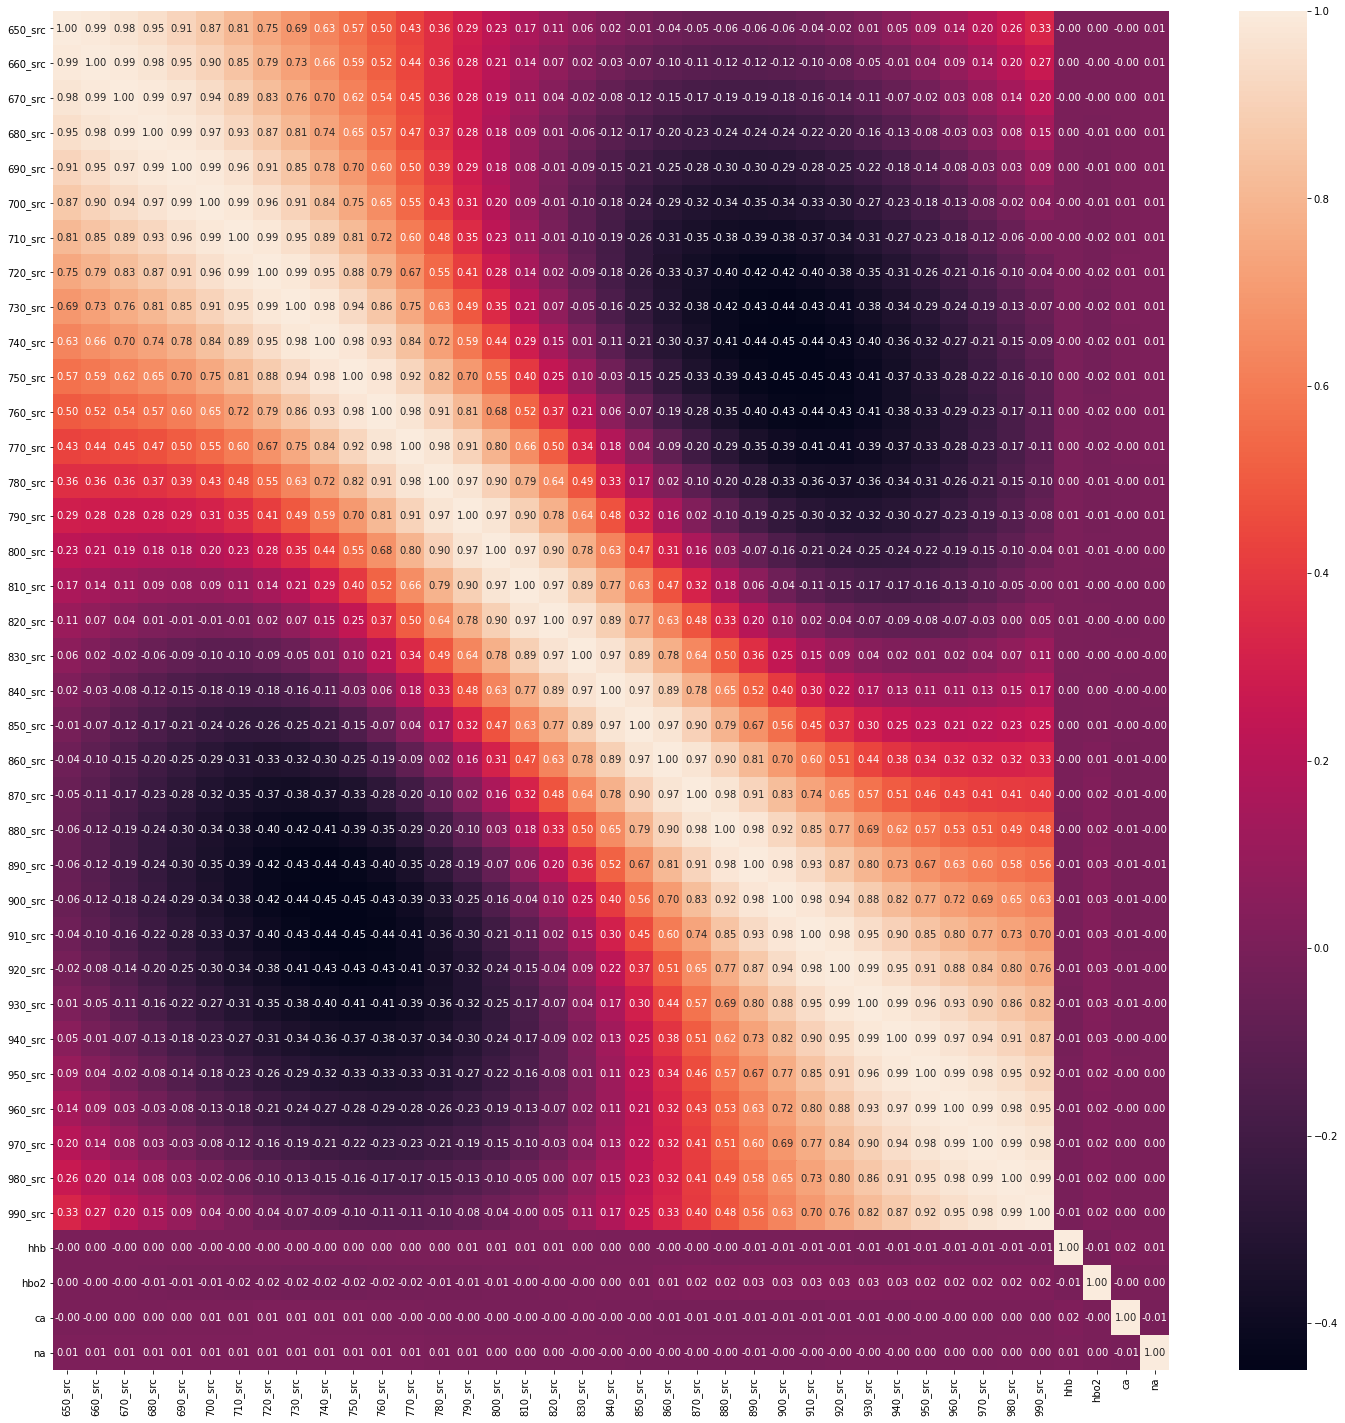

In [20]:
fig, ax = plt.subplots(figsize = (25, 25))

sns.heatmap(train[src_column].corr(), annot=True, fmt='.2f', ax=ax)
plt.show()

**dst 데이터와 종속변수간의 상관관계 파악**

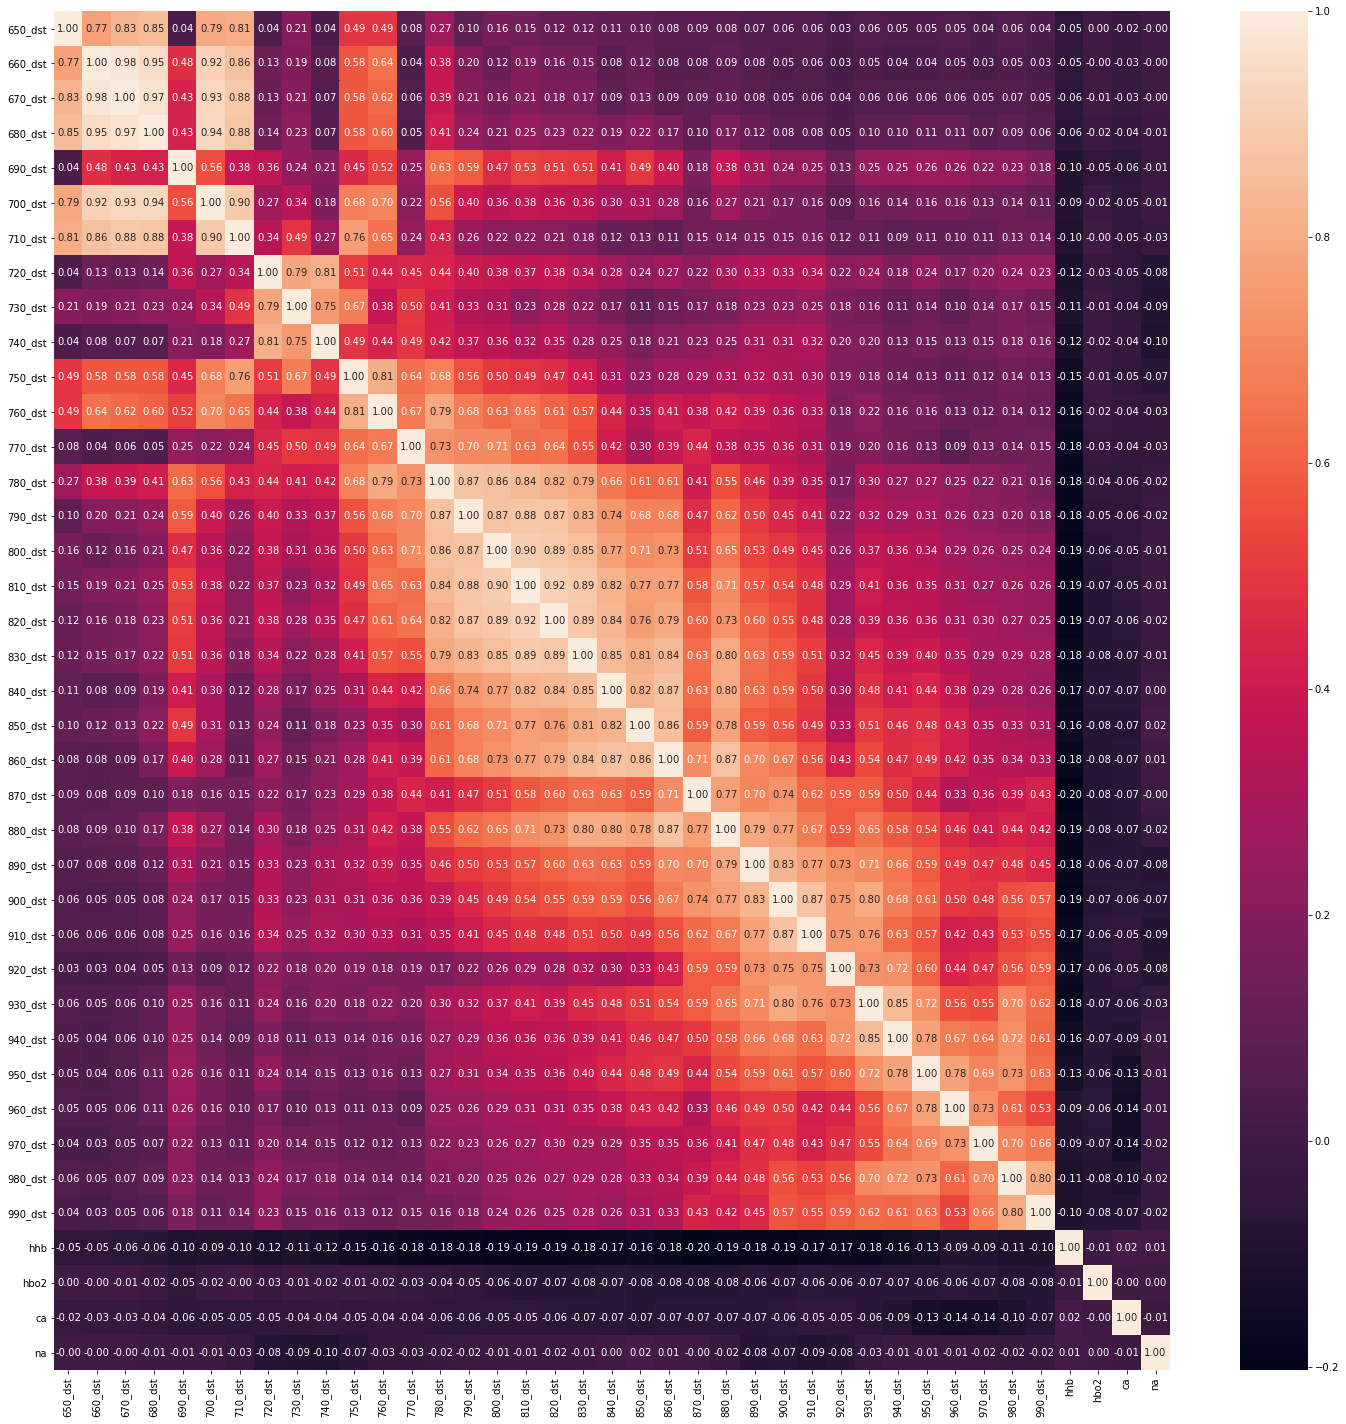

In [21]:
fig, ax = plt.subplots(figsize = (25, 25))

sns.heatmap(train[dst_column].corr(), annot=True, fmt='.2f', ax=ax)
plt.show()

# 3. Model

**Use random forest algorithm**

### Make model

In [22]:
train_hhb = split_y(train, 'hhb')
train_hbo2 = split_y(train, 'hbo2')
train_na = split_y(train, 'na')
train_ca = split_y(train, 'ca')

## hhb train

In [23]:
train_hhb.drop(['id'], axis=1, inplace=True)

In [24]:
#split train and test

X = train_hhb.iloc[:, :-1]
y = train_hhb.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [25]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

y_pred_train = pd.DataFrame(y_pred_train, columns = ['hhb'])
y_pred_test = pd.DataFrame(y_pred_test, columns = ['hhb'])

# for col in y_pred_train.columns :
print("train r-squared of {0} columns is {1} ".format('hhb', round(r2_score(y_train, y_pred_train), 2)))
print("test r-squared of {0} columns is {1} ".format('hhb', round(r2_score(y_test, y_pred_test), 2)))

train r-squared of hhb columns is 0.97 
test r-squared of hhb columns is 0.76 


## hbo2 train

In [26]:
train_hbo2.drop(['id'], axis=1, inplace=True)

In [27]:
#split train and test

X = train_hbo2.iloc[:, :-1]
y = train_hbo2.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [78]:
make_y2 = train_hbo2.iloc[:0, -1]

In [87]:
make_y2

Series([], Name: hbo2, dtype: float64)

In [64]:
make_xc = train_hbo2.iloc[:0, 1:-1]

In [65]:
make_yc = train_hbo2.iloc[:, -1]

In [28]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

y_pred_train = pd.DataFrame(y_pred_train, columns = ['hbo2'])
y_pred_test = pd.DataFrame(y_pred_test, columns = ['hbo2'])

# for col in y_pred_train.columns :
print("train r-squared:{}".format(round(r2_score(y_train, y_pred_train), 2)))
print("test r-squared:{}".format(round(r2_score(y_test, y_pred_test), 2)))

train r-squared:0.89
test r-squared:0.23


In [49]:
def create_model(train, val):
    params = {
        'metric': 'mae',
        'seed':7777
        }

    model = lgb.train(params, d_train, 1000, d_val, verbose_eval=1000, early_stopping_rounds=100)
    
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.plot(np.array(y_val), '.-', label='y_val')
    plt.plot(model.predict(x_val), '.-', label='y_pred')
    plt.title(str(future)+'days later')
    plt.legend()
    plt.show()

    return model

In [75]:
def trans(dataset, start_index, end_index, past, future, x_columns, y_columns):
    dataset.index = range(dataset.shape[0])
    data = []
    labels = []
    
    start_index = start_index + past
    
    if end_index is None:
        end_index = dataset.shape[0]
    
    for i in range(start_index, end_index-future):
        indices = np.array(dataset.loc[i-past:i, x_columns])
        data.append(indices)
        
        labels.append(np.array(dataset.loc[i+future, y_columns]))
        
    data = np.array(data)
    data = data.reshape(data.shape[0], -1)
    labels = np.array(labels)
    labels = labels.reshape(-1)
    
    return data, labels

In [88]:
past=1000
x_columns = ['650_src','660_src','670_src','680_src','690_src','700_src','710_src','720_src','730_src','740_src','750_src','760_src','770_src','780_src','790_src','800_src','810_src','820_src','830_src','840_src','850_src','860_src','870_src','880_src','890_src','900_src','910_src','920_src','930_src','940_src','950_src','960_src','970_src','980_src','990_src','650_dst','660_dst','670_dst','680_dst','690_dst','700_dst','710_dst','720_dst','730_dst','740_dst','750_dst','760_dst','770_dst','780_dst','790_dst','800_dst','810_dst','820_dst','830_dst','840_dst','850_dst','860_dst','870_dst','880_dst','890_dst','900_dst','910_dst','920_dst','930_dst','940_dst','950_dst','960_dst','970_dst','980_dst','990_dst']
y_columns = ['hbo2']
supply_models = {}

In [89]:
x_columns

['650_src',
 '660_src',
 '670_src',
 '680_src',
 '690_src',
 '700_src',
 '710_src',
 '720_src',
 '730_src',
 '740_src',
 '750_src',
 '760_src',
 '770_src',
 '780_src',
 '790_src',
 '800_src',
 '810_src',
 '820_src',
 '830_src',
 '840_src',
 '850_src',
 '860_src',
 '870_src',
 '880_src',
 '890_src',
 '900_src',
 '910_src',
 '920_src',
 '930_src',
 '940_src',
 '950_src',
 '960_src',
 '970_src',
 '980_src',
 '990_src',
 '650_dst',
 '660_dst',
 '670_dst',
 '680_dst',
 '690_dst',
 '700_dst',
 '710_dst',
 '720_dst',
 '730_dst',
 '740_dst',
 '750_dst',
 '760_dst',
 '770_dst',
 '780_dst',
 '790_dst',
 '800_dst',
 '810_dst',
 '820_dst',
 '830_dst',
 '840_dst',
 '850_dst',
 '860_dst',
 '870_dst',
 '880_dst',
 '890_dst',
 '900_dst',
 '910_dst',
 '920_dst',
 '930_dst',
 '940_dst',
 '950_dst',
 '960_dst',
 '970_dst',
 '980_dst',
 '990_dst']

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 0.83612


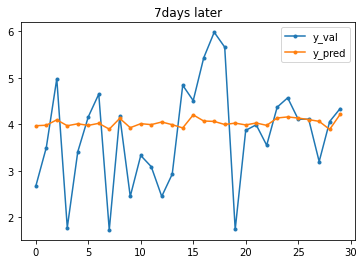

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[32]	valid_0's l1: 0.836026


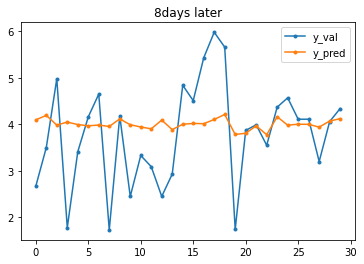

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[48]	valid_0's l1: 0.786407


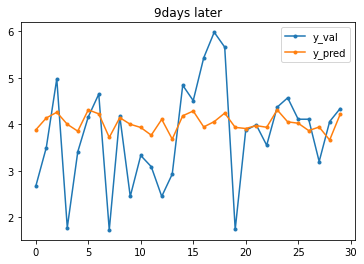

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[83]	valid_0's l1: 0.848256


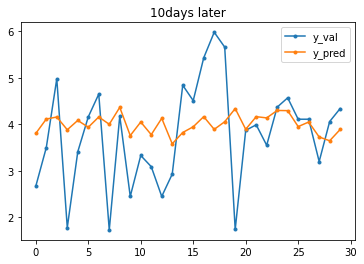

Training until validation scores don't improve for 100 rounds


KeyboardInterrupt: 

In [90]:
for future in range(7, 35):
    train_split = train.shape[0]-past-future-30 # 마지막 30일을 validation set으로 사용
    x_train, y_train = trans(train, 0, train_split, past, future, x_columns, y_columns)
    x_val, y_val = trans(train, train_split, None, past, future, x_columns, y_columns)
    
    d_train = lgb.Dataset(x_train, y_train)
    d_val = lgb.Dataset(x_val, y_val)

    supply_models[future] = create_model(d_train, d_val)
    print('==========================================================================')

In [44]:
X_train.head()

,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,740_src,750_src,760_src,770_src,780_src,790_src,800_src,810_src,820_src,830_src,840_src,850_src,860_src,870_src,880_src,890_src,900_src,910_src,920_src,930_src,940_src,950_src,960_src,970_src,980_src,990_src,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,750_dst,760_dst,770_dst,780_dst,790_dst,800_dst,810_dst,820_dst,830_dst,840_dst,850_dst,860_dst,870_dst,880_dst,890_dst,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
7389,10,-0.227198,-0.241556,-0.184637,-0.195975,-0.241899,-0.252859,-0.268751,-0.272998,-0.332182,-0.412433,-0.470814,-0.579351,-0.638164,-0.676402,-0.716643,-0.756340,-0.761697,-0.715885,-0.673654,-0.609780,-0.484286,-0.369126,-0.222802,-0.051578,0.173850,0.405933,0.611116,0.811324,1.088406,1.282573,1.584096,1.843205,2.031667,2.270067,2.372828,16062.037514,5231.214166,18127.879442,0.000000,6985.916363,8861.021208,0.000000,820.716457,0.000000,-0.000300,1478.799488,0.000000,-0.000394,51.993611,11.261286,-0.002693,0.000000,0.000000,106.758563,152.923981,0.000000,528.373386,801.492866,1301.917478,0.000000,2139.846678,0.000000,2901.157264,5245.617754,0.000000,6225.093797,5711.803822,5343.177873,2860.363552,2077.704810
9275,15,-0.191745,-0.232283,-0.239670,-0.236173,-0.229121,-0.252859,-0.270745,-0.289807,-0.343920,-0.412433,-0.493080,-0.576608,-0.655200,-0.703708,-0.744182,-0.765387,-0.764474,-0.713893,-0.667920,-0.473098,-0.291402,-0.032539,0.295749,0.563742,0.756407,0.830328,0.760872,0.637869,0.454300,0.295885,0.124984,-0.027920,-0.156561,-0.191861,-0.235508,-0.000065,5.365636,-0.000066,0.000000,0.000000,3.633476,0.000000,0.000000,1.224140,0.511888,0.000000,-0.000319,-0.000394,-0.000920,0.000000,-0.002693,0.005088,0.033970,0.000000,0.000000,0.197433,0.000000,0.607533,1.161635,0.000000,2.711250,3.325239,2.540034,1.358752,0.323926,-0.000263,-0.000205,0.015451,0.000000,-0.002475
2995,20,1.147544,1.013377,0.974802,0.890836,0.832378,0.724083,0.692004,0.674903,0.674721,0.727357,0.720949,0.737810,0.689300,0.687052,0.568273,0.486337,0.369730,0.282273,0.137409,0.079360,-0.021159,-0.102742,-0.142077,-0.195547,-0.167490,-0.109586,-0.074412,-0.060284,-0.031210,0.045131,0.086234,0.096094,0.168555,0.144521,0.259660,0.017867,0.020378,0.050851,0.028406,-0.000102,0.109407,0.068430,0.000000,-0.000245,0.030172,0.014772,0.003011,-0.000158,0.000456,-0.002174,-0.001898,-0.002553,-0.002371,-0.002250,-0.001921,-0.002156,-0.001900,-0.002008,-0.001864,0.001018,-0.000593,0.000661,0.000000,-0.000339,0.000163,0.001766,-0.000205,0.003686,0.001445,0.002866
5316,20,0.304607,0.320941,0.156267,0.168508,0.104486,0.058795,0.015665,0.010547,-0.033425,-0.038833,-0.102531,-0.073168,-0.080291,-0.025629,0.020079,0.143741,0.245594,0.393259,0.494225,0.610700,0.726570,0.758150,0.702083,0.666870,0.640923,0.587481,0.573891,0.524601,0.540422,0.581026,0.630632,0.613205,0.747746,0.771538,0.810206,-0.000065,0.006066,-0.000066,0.019018,0.007932,-0.000147,0.000000,0.003821,0.000716,0.000000,-0.000187,-0.000319,-0.000394,-0.000916,-0.002322,-0.002527,-0.002994,-0.002908,-0.002607,-0.002181,-0.002342,-0.002210,0.000000,-0.001427,-0.000869,-0.000327,-0.000240,-0.000010,-0.000447,-0.000517,0.001186,0.000000,-0.000416,-0.000924,-0.000990
356,10,3.360594,2.810878,2.506261,2.085412,1.761679,1.427558,1.234298,1.032307,0.902070,0.742693,0.606609,0.484222,0.354235,0.217034,0.070959,0.008159,-0.111285,-0.209415,-0.333359,-0.380811,-0.466967,-0.508513,-0.541358,-0.526976,-0.455214,-0.405454,-0.353197,-0.273059,-0.262419,-0.210581,-0.237604,-0.231658,-0.179549,-0.236569,-0.202621,3065.666205,0.000000,0.000000,6737.247256,773.215619,-0.000147,-0.000159,3137.892286,691.339465,963.957553,1011.767162,573.269215,0.000000,108.984075,69.453195,0.000000,40.561170,35.816329,27.659380,26.612978,0.000000,17.450598,15.586881,20.098998,31.375966,0.000000,17.131995,31.453236,0.000000,16.833210,-0.000263,6.283230,79.806671,0.000000,6.568206


In [41]:
y_pred_test.head()

,ca
0,6.6982
1,8.4527
2,9.8514
3,9.0988
4,8.5284


## na train

In [29]:
train_na.drop(['id'], axis=1, inplace=True)

In [30]:
#split train and test

X = train_na.iloc[:, :-1]
y = train_na.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [31]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

y_pred_train = pd.DataFrame(y_pred_train, columns = ['na'])
y_pred_test = pd.DataFrame(y_pred_test, columns = ['na'])

# for col in y_pred_train.columns :
print("train r-squared:{}".format(round(r2_score(y_train, y_pred_train), 2)))
print("test r-squared:{}".format(round(r2_score(y_test, y_pred_test), 2)))

train r-squared:0.88
test r-squared:0.16


## ca train

In [32]:
train_ca.drop(['id'], axis=1, inplace=True)

In [33]:
#split train and test

X = train_ca.iloc[:, :-1]
y = train_ca.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [34]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

y_pred_train = pd.DataFrame(y_pred_train, columns = ['ca'])
y_pred_test = pd.DataFrame(y_pred_test, columns = ['ca'])

# for col in y_pred_train.columns :
print("train r-squared:{}".format(round(r2_score(y_train, y_pred_train), 2)))
print("test r-squared:{}".format(round(r2_score(y_test, y_pred_test), 2)))

train r-squared:0.9
test r-squared:0.27


**train에 비해 test의 performance가 너무 작음**  
**예측값을 높이기 위해 변수간 다중공선성을 줄여줌**

In [35]:
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [36]:
pd.set_option('display.max_rows', 500)
vif.round(1)

,VIF Factor,features
0,2.3,rho
1,291.3,650_src
2,643.5,660_src
3,732.4,670_src
4,755.7,680_src
5,792.3,690_src
6,768.3,700_src
7,753.3,710_src
8,771.9,720_src
9,718.2,730_src


**src column이 다중공선성이 높으므로 모두 drop**

In [37]:
#check feature importance
importance = rf.feature_importances_
x_columns = X.columns

importance = pd.Series(importance, index = x_columns)

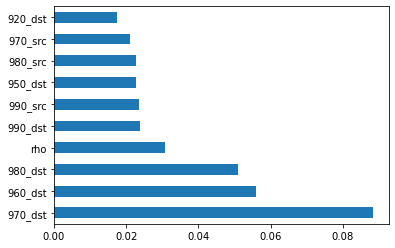

In [38]:
ax = importance.nlargest(10).plot.barh()

**src보다는 dst와 rho가 더 중요함**